In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from math import sin, cos, pi

def rot(ev, theta):
    R = np.array([[cos(theta), -sin(theta)], [sin(theta), cos(theta)]])
    return np.dot(np.dot(R, np.diag(ev)), R.T)

Fisher's determinant
---

Here we use Fisher's determinant to separate two Gaussian clusters of data.

In [4]:
sigma1 = rot([0.5, 0.1], pi/4)
sigma2 = rot([0.6, 0.2], pi/2)
mu1 = np.array([1.0, 0.0])
mu2 = np.array([-1.0, 1.0])

In [5]:
samples1 = np.random.multivariate_normal(mu1, sigma1, 100)
samples2 = np.random.multivariate_normal(mu2, sigma2, 100)

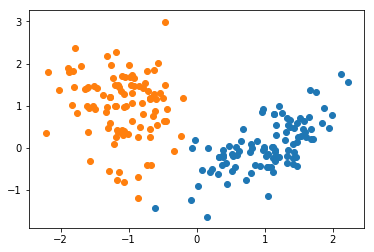

In [6]:
plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

In [7]:
xs = np.linspace(-2, 2, 100)
ys = np.linspace(-2, 3, 100)
X, Y = np.meshgrid(xs, ys)
XY = np.stack([X, Y], axis=-1)

In [8]:
d1 = XY - mu1
d2 = XY - mu2
prec1 = np.linalg.pinv(sigma1)
prec2 = np.linalg.pinv(sigma2)
f = np.log(np.linalg.det(sigma2)/np.linalg.det(sigma1))

fisher = (
    0.5 * np.einsum("ijk, kl, ijl -> ij", d1, prec1, d1) - 
    0.5 * np.einsum("ijk, kl, ijl -> ij", d2, prec2, d2) + f
)

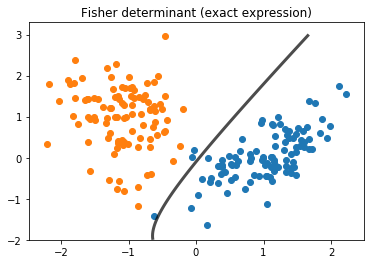

In [9]:
plt.contour(X, Y, fisher, [0], colors='k', linewidths=3, alpha=0.7)

plt.scatter(*samples1.T)
plt.scatter(*samples2.T)
plt.title("Fisher determinant (exact expression)");

In [10]:
sigma = (sigma1 + sigma2) / 2
prec = np.linalg.pinv(sigma)

fisher_linear = (
    np.einsum("i,ij,klj", mu1 - mu2, prec, XY)
    - 0.5 * (np.dot(mu1, np.dot(prec, mu1)) - np.dot(mu2, np.dot(prec, mu2)))
)

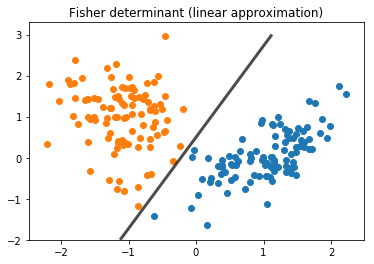

In [11]:
plt.contour(X, Y, fisher_linear, [0], colors='k', linewidths=3, alpha=0.7)

plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

plt.title("Fisher determinant (linear approximation)");

Linearly separable clusters, SVM
---

In [12]:
mu1 = np.array([-3.0, -2.5])
mu20 = np.array([-1.0, 1.5])
mu21 = np.array([1.2, -2.0])
sigma1 = rot([0.5, 0.5], 0)
sigma20 = rot([0.8, 0.2], 0)
sigma21 = rot([0.2, 0.8], 0)

samples1 = np.random.multivariate_normal(mu1, sigma1, 20)
samples20 = np.random.multivariate_normal(mu20, sigma20, 10)
samples21 = np.random.multivariate_normal(mu21, sigma21, 10)
samples2 = np.vstack([samples20, samples21])

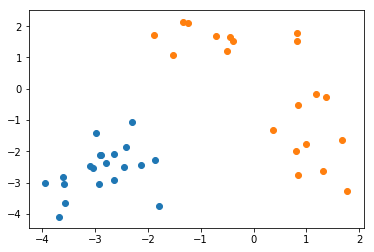

In [13]:
plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

In [86]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import norm

gamma = 1.0

points = np.vstack([samples1, samples2])

n = samples1.shape[0]
dist = squareform(pdist(points))
kernel = np.exp(-dist ** 2 / (2*gamma**2))
 
#kernel = np.empty((2*n, 2*n), dtype=float)
#for i in range(2*n):
#    for j in range(2*n):
#        kernel[i, j] = np.dot(points[i], points[j])
    
signs = np.array(n*[1] + n*[-1])
signed_kernel = kernel * np.outer(signs, signs)

In [87]:
import cvxopt

In [88]:
N = 2*n

P = cvxopt.matrix(signed_kernel)
q = cvxopt.matrix(-np.ones(N), tc='d')
G = cvxopt.matrix(-np.eye(N), tc='d')
h = cvxopt.matrix(np.zeros(N), tc='d')
A = cvxopt.matrix(signs[np.newaxis, :], tc='d')
b = cvxopt.matrix([0], tc='d')

In [89]:
sol = cvxopt.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -3.2307e+00 -9.7807e+00  7e+00  3e-16  1e+00
 1: -3.4473e+00 -4.1183e+00  7e-01  5e-16  2e-01
 2: -3.6530e+00 -3.8025e+00  1e-01  1e-15  3e-02
 3: -3.7052e+00 -3.7341e+00  3e-02  5e-16  5e-03
 4: -3.7199e+00 -3.7211e+00  1e-03  1e-15  3e-06
 5: -3.7206e+00 -3.7207e+00  3e-05  1e-15  4e-08
 6: -3.7206e+00 -3.7206e+00  6e-07  9e-16  4e-10
Optimal solution found.


In [90]:
a = np.squeeze(np.array(sol['x'])); a

array([  1.45196345e-08,   3.31727958e-08,   2.05467863e-08,
         4.61413947e-08,   8.25627003e-01,   3.67803871e-08,
         6.87347882e-01,   8.86065926e-01,   1.54888998e-08,
         1.22511433e-07,   6.46546376e-01,   1.83493569e-08,
         1.58286567e-08,   2.97382196e-08,   1.59517173e-08,
         2.55798196e-08,   2.92581358e-08,   3.84967887e-01,
         2.90084196e-01,   1.84478475e-08,   7.66467186e-07,
         1.29850449e-02,   8.96827526e-02,   1.50356682e-06,
         1.09295393e-07,   5.65908617e-01,   1.05656348e-07,
         3.65322007e-01,   6.89284553e-01,   1.21659300e-06,
         5.81827685e-08,   2.30598641e-08,   1.84965691e-08,
         2.70926962e-01,   4.88688204e-01,   1.80253655e-01,
         4.77846030e-01,   1.16012558e-06,   5.79736898e-01,
         2.70803807e-08])

In [91]:
dist = pdist(points)

In [92]:
u = np.exp(-squareform(dist)**2 / 0.1)

In [93]:
np.linalg.cond(u)

1376.8415824513406

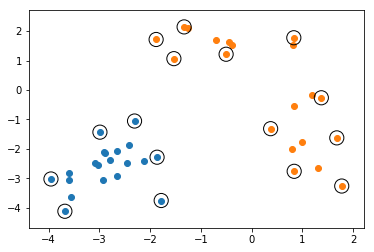

In [94]:
plt.scatter(*samples1.T)
plt.scatter(*samples2.T)

support_vectors = a > 1e-5

plt.scatter(*points[support_vectors].T, edgecolors='black', facecolors='none', s=200)